In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from prompter import FastPromptBuilder
from data import VOC2012SegDataset
from path import get_mask_prs_path
from models.vl_models import GenParams
from viz import display_prompt

from pathlib import Path
from torchvision.transforms.functional import to_pil_image

In [3]:
by_model = "LRASPP_MobileNet_V3"

gen_params = GenParams(
    seed=CONFIG["seed"],
    temperature=0.1
)

In [4]:
prompt_blueprint={
        "context": "default",
        "color_map": "default",
        "input_format": "sep_ovr_original",
        "task": "default",
        "output_format": "default",
        "support_set_intro": "default",
        "support_set_item": "default",
        "query": "default",
}

offset = CONFIG['data_gen']['offset']

seg_dataset = VOC2012SegDataset(
    root_path=Path("/home/olivieri/exp/data/VOCdevkit"),
    split='prompts_split',
    resize_size=CONFIG['segnet']['image_size'],
    center_crop=True,
    with_unlabelled=False,
    mask_prs_path=get_mask_prs_path(by_model=by_model)
)

sup_set_seg_dataset = VOC2012SegDataset(
    root_path=Path("/home/olivieri/exp/data/VOCdevkit"),
    split='prompts_split',
    resize_size=CONFIG['segnet']['image_size'],
    center_crop=True,
    with_unlabelled=False,
    mask_prs_path=get_mask_prs_path(by_model=by_model)
)
len(seg_dataset)

80

In [5]:
fast_prompt_builder = FastPromptBuilder(
    seg_dataset=seg_dataset,
    seed=CONFIG["seed"],
    prompt_blueprint=prompt_blueprint,
    by_model=by_model,
    alpha=0.6,
    class_map=seg_dataset.get_class_map(with_unlabelled=False),
    color_map=seg_dataset.get_color_map_dict(with_void=False),
    image_size=CONFIG['vlm']['image_size'],
    sup_set_img_idxs=[16],
    sup_set_seg_dataset=sup_set_seg_dataset,
    str_formats=None,
    prs_mask_paths=get_mask_prs_path(by_model=by_model)
)

# Single Sample

In [6]:
query_idx = 0

In [7]:
class_splitted_inference_prompt = fast_prompt_builder.build_cs_inference_prompts_from_disk([query_idx])
class_splitted_inference_prompt[0].keys()

dict_keys([1, 15])

I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.


In both masks, a color-class mapping is applied: the white color is mapped to the AEROPLANE class, while the black color refers to unlabelled classes.


I will give you two images: the first image is the ground truth mask, the second image is the prediction mask.
Both images are overlaid with the scene to support your analysis.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


I provide some examples of correct outputs:
- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN region on the center of the scene is incomplete."
- "The prediction mask is quite chaotic, many GRASS regions have been hallucinated all over the scene, while the TREE region has been over-extended towards the top."
- "The ground truth WATER region on the bottom has been segmented with a coarse, irregular shape, especially on the boundary."


To help you, I will give you a set of example images, each associated with an ideal answer, which might mention classes whose names are irrelevant to your problem.


EXAMPLE 1.

Input:

Ground Truth.

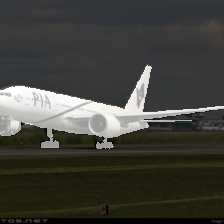

Prediction.

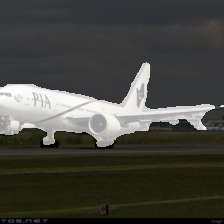

Output:

The ground truth AEROPLANE region has been segmented quite well by the prediction, but the boundaries are imprecise and less defined.

Now, I ask you to generate the output based on the following input. Remember the considered class is the AEROPLANE class, reference it explicitely in the answer.


Input:

Ground Truth.

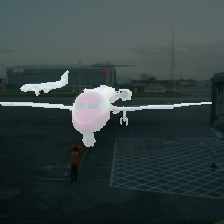

Prediction.

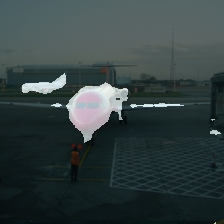

Output:

In [8]:
display_prompt(class_splitted_inference_prompt[0][1])

# Batch

In [9]:
epoch_idxs = [x for x in list(range(80)) if x not in [16]]
len(epoch_idxs)

79

In [10]:
class_splitted_inference_prompts = fast_prompt_builder.build_cs_inference_prompts_from_disk(epoch_idxs)


In [11]:
idx = 30

In [12]:
class_splitted_inference_prompts[idx].keys()

dict_keys([11, 15, 16])

I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.


In both masks, a color-class mapping is applied: the white color is mapped to the POTTEDPLANT class, while the black color refers to unlabelled classes.


I will give you two images: the first image is the ground truth mask, the second image is the prediction mask.
Both images are overlaid with the scene to support your analysis.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


I provide some examples of correct outputs:
- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN region on the center of the scene is incomplete."
- "The prediction mask is quite chaotic, many GRASS regions have been hallucinated all over the scene, while the TREE region has been over-extended towards the top."
- "The ground truth WATER region on the bottom has been segmented with a coarse, irregular shape, especially on the boundary."


To help you, I will give you a set of example images, each associated with an ideal answer, which might mention classes whose names are irrelevant to your problem.


EXAMPLE 1.

Input:

Ground Truth.

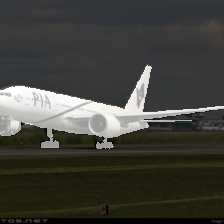

Prediction.

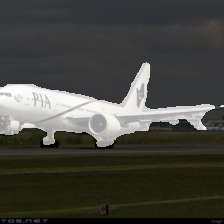

Output:

The ground truth AEROPLANE region has been segmented quite well by the prediction, but the boundaries are imprecise and less defined.

Now, I ask you to generate the output based on the following input. Remember the considered class is the POTTEDPLANT class, reference it explicitely in the answer.


Input:

Ground Truth.

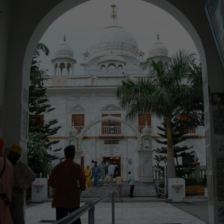

Prediction.

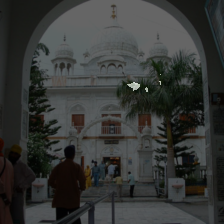

Output:

In [13]:
display_prompt(class_splitted_inference_prompts[idx][16])

# Pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from models.vl_models import GenParams, OllamaMLLM
from prompter import FastPromptBuilder
from data import append_many_to_jsonl, VOC2012SegDataset, crop_augment_preprocess_batch
from color_map import apply_colormap
from path import get_mask_prs_path
from utils import blend_tensors, create_directory

from pathlib import Path
from torchvision.models import segmentation as segmodels
from functools import partial
import torchvision
from torchvision.transforms._presets import SemanticSegmentation
import torchvision.transforms.v2 as T
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torchvision import tv_tensors
from collections import OrderedDict

import asyncio

import torch

In [3]:
def create_diff_mask(
        mask1: torch.Tensor,
        mask2: torch.Tensor,
) -> torch.Tensor:
    """
    Creates a binary difference mask from two integer-based segmentation masks.

    The operation is fully vectorized and runs efficiently on CUDA devices.

    Args:
        mask1 (torch.Tensor): The first segmentation mask with class indices.
                              Expected dtype: torch.long, torch.int, etc.
        mask2 (torch.Tensor): The second segmentation mask with class indices.
                              Must have the same shape and device as mask1.

    Returns:
        torch.Tensor: A mask with value 255 (uint8) where pixels in mask1 and mask2
                      are different, and 0 where they are the same.
    """
    # 1. Ensure the masks have the same shape for element-wise comparison.
    assert mask1.shape == mask2.shape, f"Input masks must have the same shape, but got {mask1.shape} and {mask2.shape}"
    
    # 2. Perform element-wise comparison. This creates a boolean tensor.
    #    'True' where elements are not equal, 'False' where they are equal.
    #    This is the functional equivalent of `torch.ne(mask1, mask2)`.
    diff = (mask1 != mask2).to(torch.uint8)
    
    return diff

In [4]:
exp_path = create_directory(Path(CONFIG['data_gen']['data_root']), CONFIG['data_gen']['exp_name'])
images_RB_path = create_directory(exp_path,  "images_RB")
images_L_path = create_directory(exp_path,  "images_L")
captions_path = exp_path / "captions.jsonl"

model_name = "gemma3:12b-it-qat"

by_model = "LRASPP_MobileNet_V3"

gen_params = GenParams(
    seed=CONFIG["seed"],
    temperature=CONFIG['data_gen']['temperature'],
    top_p=CONFIG['data_gen']['top_p']
)

In [5]:
offset = CONFIG['data_gen']['offset']

seg_dataset = VOC2012SegDataset(
    root_path=Path("/home/olivieri/exp/data/VOCdevkit"),
    split='train',
    resize_size=CONFIG['segnet']['image_size'],
    center_crop=True,
    with_unlabelled=False,
    uids_to_exclude=['2007_000256']
)
print(f"{len(seg_dataset)} unique images.")

sup_set_seg_dataset = VOC2012SegDataset(
    root_path=Path("/home/olivieri/exp/data/VOCdevkit"),
    split='prompts_split',
    resize_size=CONFIG['segnet']['image_size'],
    center_crop=True,
    with_unlabelled=False,
    mask_prs_path=get_mask_prs_path(by_model=by_model)
)

1463 unique images.


In [6]:
prompt_blueprint={
        "context": "default",
        "color_map": "default",
        "input_format": "sep_ovr_original",
        "task": "default",
        "output_format": "default",
        "support_set_intro": "default",
        "support_set_item": "default",
        "query": "default",
}

In [7]:
fast_prompt_builder = FastPromptBuilder(
    seg_dataset=seg_dataset,
    seed=CONFIG["seed"],
    prompt_blueprint=prompt_blueprint,
    by_model=by_model,
    alpha=0.6,
    class_map=seg_dataset.get_class_map(with_unlabelled=False),
    color_map=seg_dataset.get_color_map_dict(with_void=False),
    image_size=CONFIG['vlm']['image_size'],
    sup_set_img_idxs=[16],
    sup_set_seg_dataset=sup_set_seg_dataset,
    str_formats=None,
)

In [8]:
segnet = segmodels.lraspp_mobilenet_v3_large(weights=None, weights_backbone=None).to(CONFIG["device"])
segnet.load_state_dict(torch.load(TORCH_WEIGHTS_CHECKPOINTS / ("lraspp_mobilenet_v3_large-full-pt" + ".pth")))
segnet.requires_grad_(False)
segnet.eval();

In [9]:
preprocess_fn = partial(SemanticSegmentation, resize_size=CONFIG['segnet']['image_size'])() # same as original one, but with custom resizing

collate_fn = partial(
    crop_augment_preprocess_batch,
    crop_fn=T.CenterCrop(CONFIG['segnet']['image_size']),
    augment_fn=None,
    preprocess_fn=None
)

dl = DataLoader(
    seg_dataset,
    batch_size=CONFIG["data_gen"]["batch_size"],
    shuffle=False,
    generator=get_torch_gen(),
    collate_fn=collate_fn,
)

In [21]:
with torch.inference_mode():

    img_idx_count = 0
    cs_img_idx_count = 0

    for step, (scs_img, gts) in enumerate(dl):

        if preprocess_fn: scs = preprocess_fn(scs_img)

        scs = scs.to(CONFIG["device"])
        gts = gts.to(CONFIG["device"]) # shape [N, H, W]

        logits = segnet(scs)
        logits: torch.Tensor = logits["out"] if isinstance(logits, OrderedDict) else logits # shape [N, C, H, W]
        prs = logits.argmax(dim=1, keepdim=True)
        
        scs_img = (scs_img*255).to(torch.uint8)

        gts = gts.unsqueeze(1)

        # Both VLM and VLE receive the images in the same size.
        gts_down = TF.resize(gts, fast_prompt_builder.image_size, TF.InterpolationMode.NEAREST)
        prs_down = TF.resize(prs, fast_prompt_builder.image_size, TF.InterpolationMode.NEAREST)
        scs_down = TF.resize(scs_img, fast_prompt_builder.image_size, TF.InterpolationMode.BILINEAR)
        
        cs_prompts = fast_prompt_builder.build_cs_inference_prompts(gts_down, prs_down, scs_down)

        batch_idxs = [offset + dl.batch_size*step + i for i in range(len(scs_down))]
        batch_image_uids = seg_dataset.image_UIDs[batch_idxs]

KeyboardInterrupt: 

In [22]:
from viz import display_prompt

In [23]:
cs_prompts[0].keys()

dict_keys([19])

I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.


In both masks, a color-class mapping is applied: the white color is mapped to the TRAIN class, while the black color refers to unlabelled classes.


I will give you two images: the first image is the ground truth mask, the second image is the prediction mask.
Both images are overlaid with the scene to support your analysis.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


I provide some examples of correct outputs:
- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN region on the center of the scene is incomplete."
- "The prediction mask is quite chaotic, many GRASS regions have been hallucinated all over the scene, while the TREE region has been over-extended towards the top."
- "The ground truth WATER region on the bottom has been segmented with a coarse, irregular shape, especially on the boundary."


To help you, I will give you a set of example images, each associated with an ideal answer, which might mention classes whose names are irrelevant to your problem.


EXAMPLE 1.

Input:

Ground Truth.

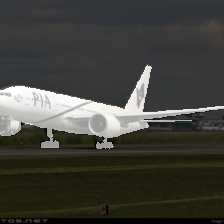

Prediction.

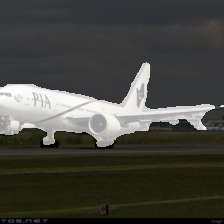

Output:

The ground truth AEROPLANE region has been segmented quite well by the prediction, but the boundaries are imprecise and less defined.

Now, I ask you to generate the output based on the following input. Remember the considered class is the TRAIN class, reference it explicitely in the answer.


Input:

Ground Truth.

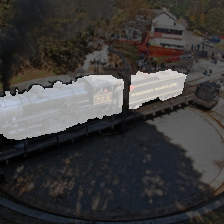

Prediction.

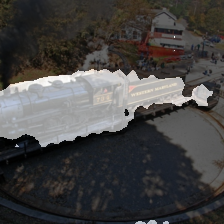

Output:

In [24]:
display_prompt(cs_prompts[0][19])